<a href="https://colab.research.google.com/github/BhardwajArjit/Causality-Informed-Segmentation/blob/main/SegFormer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import math
import torch
import torchvision

from torch import nn
from torch.nn import init
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from tqdm import tqdm


!pip install einops
from einops import rearrange

In [ ]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data")
image_path = data_path / "cityscapes_data"

if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "cityscapes_data.zip", "wb") as f:
  request = requests.get("https://github.com/BhardwajArjit/Causality-Informed-Segmentation/raw/main/cityscapes_data.zip")
  print("Downloading cityscapes data...")
  f.write(request.content)

with zipfile.ZipFile(data_path / "cityscapes_data.zip", "r") as zip_ref:
  print(f"Uzipping cityscapes data...")
  zip_ref.extractall(data_path)

data/cityscapes_data directory already exists... skipping download
Uzipping cityscapes data...


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
import os

def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/cityscapes_data'.
There are 0 directories and 2975 images in 'data/cityscapes_data/train'.
There are 0 directories and 500 images in 'data/cityscapes_data/val'.


In [ ]:
from glob import glob
train_path = glob('/content/data/cityscapes_data/train/*')
valid_path = glob('/content/data/cityscapes_data/val/*')

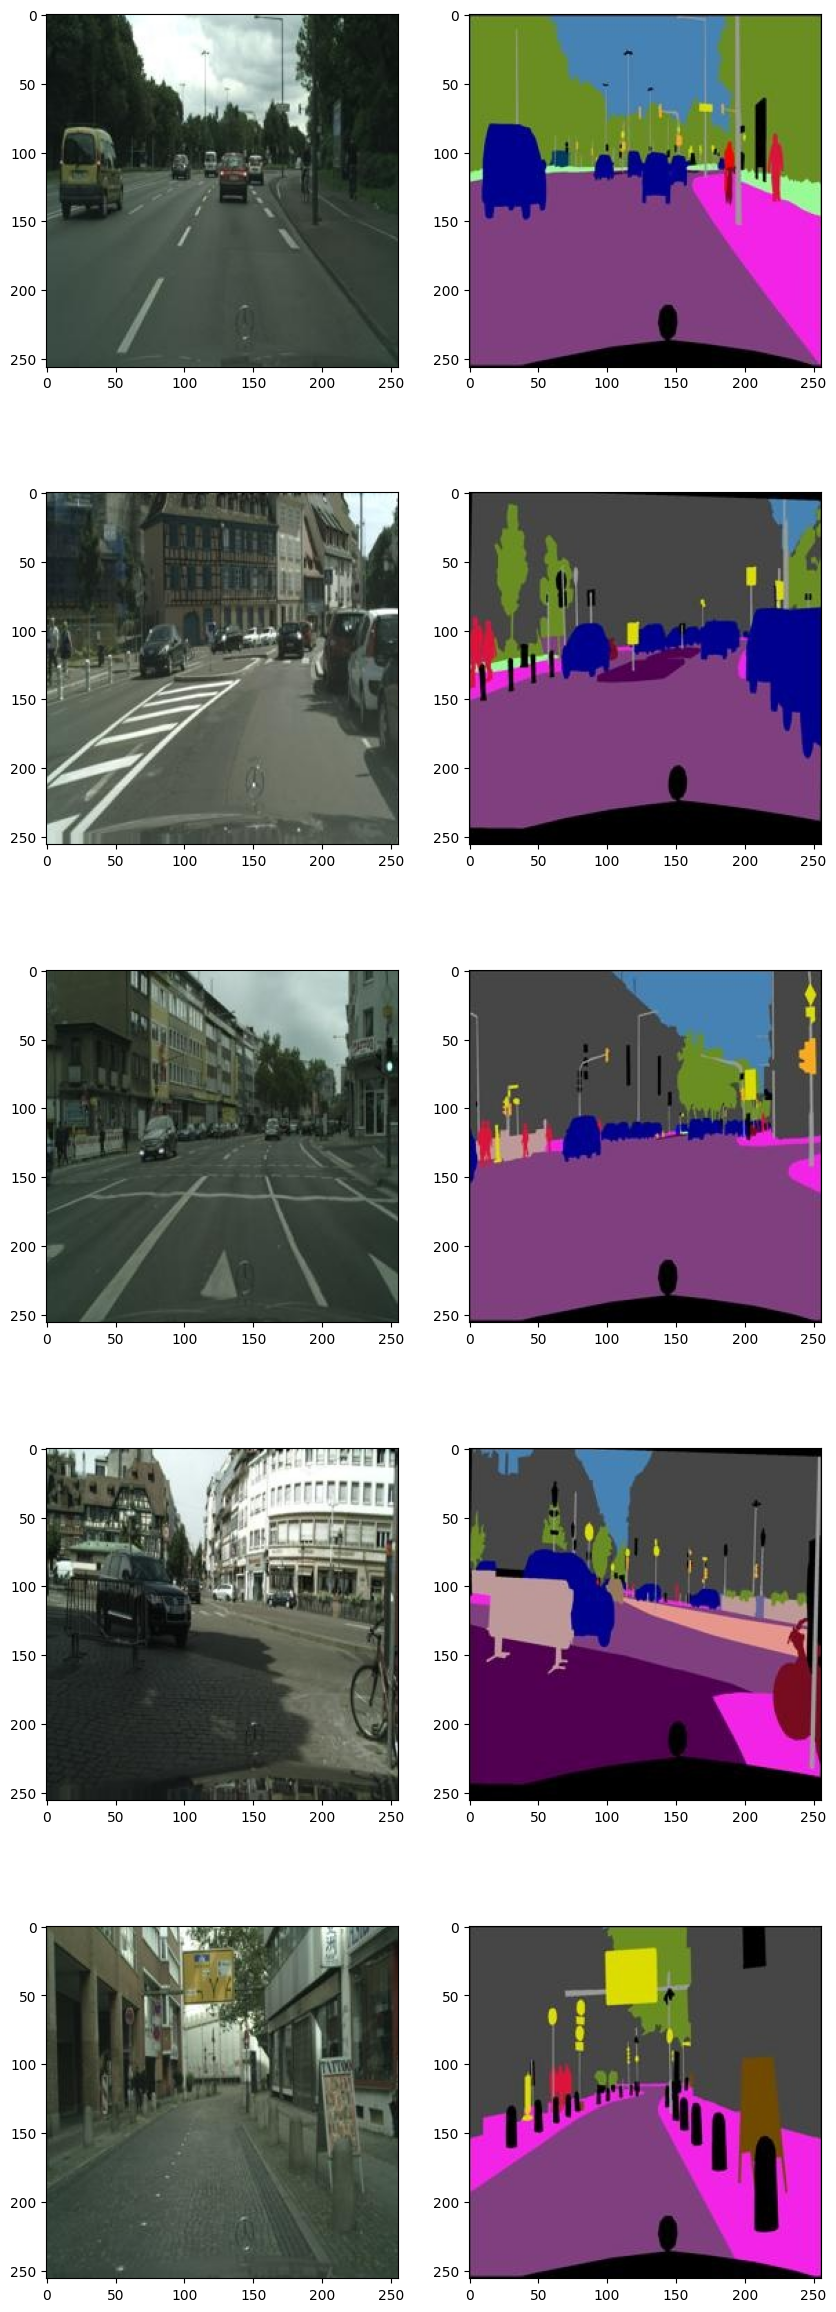

In [ ]:
fig,ax = plt.subplots(5,2,figsize=(10,30))
for i in range(5):
    img = plt.imread(train_path[i])
    ax[i][0].imshow(img[:,:256])
    ax[i][1].imshow(img[:,256:])

In [ ]:
train_dataset = []
validation_dataset = []

In [ ]:
class MyDataset(Dataset):

    def __init__(self, images_path ,transform_img=None ,transform_label=None):

        self.images_path = images_path
        self.transform_img = transform_img
        self.transform_label = transform_label

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):

        img = plt.imread(self.images_path[idx])
        image,label = img[:,:int(img.shape[1]/2)],img[:,int(img.shape[1]/2):]

        if self.transform_img:
            image = self.transform_img(image)

        if self.transform_label:
            label = self.transform_label(label)

        return image, label

In [ ]:
mytransformsImage = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.9)
    ]
)

mytransformsLabel = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224))
    ]
)

In [ ]:
# train dataset
traindata = MyDataset(train_path, mytransformsImage, mytransformsLabel)
# val dataset
valdata = MyDataset(valid_path, mytransformsImage, mytransformsLabel)

In [ ]:
# Creating the DataLoaders
batch_size = 4
train_loader = DataLoader(traindata,batch_size)
vaild_loader = DataLoader(valdata,1)

In [ ]:
def show(img,output,label,denorm = False):
    img,output,label = img.cpu(),output.cpu(),label.cpu()
    fig,ax = plt.subplots(len(output),3,figsize=(10,10))

    for i in range(len(output)):
        if(len(output) == 3):
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[i][0].imshow(Img.permute(1,2,0))
            ax[i][1].imshow(Lab)
            ax[i][2].imshow(act.permute(1,2,0))
        else:
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[0].imshow(Img.permute(1,2,0))
            ax[1].imshow(Lab)
            ax[2].imshow(act.permute(1,2,0))
    plt.show()

## SegFormer

In [ ]:
class LayerNorm2d(nn.LayerNorm):
  def forward(self, x):
    x = rearrange(x, "b c h w -> b h w c")
    x = super().forward(x)
    x = rearrange(x, "b h w c -> b c h w")
    return x

In [ ]:
class OverlapPatchMerging(nn.Sequential):
  def __init__(
      self, in_channels: int, out_channels: int, patch_size: int, overlap_size: int):
      super().__init__(
          nn.Conv2d(
              in_channels,
              out_channels,
              kernel_size=patch_size,
              stride=overlap_size,
              padding=patch_size // 2,
              bias=False
          ),
          LayerNorm2d(out_channels)
      )

In [ ]:
r = 4
channels = 8
x = torch.randn((1, channels, 64, 64))
_, _, h, w = x.shape
# we want a vector of shape 1, 8, 32, 32
x = rearrange(x, "b c h w -> b (h w) c") # shape = [1, 4096, 8]
x = rearrange(x, "b (hw r) c -> b hw (c r)", r=r) # shape = [1, 1024, 32]
reducer = nn.Linear(channels*r, channels)
x = reducer(x) # shape = [1, 1024, 8]
half_r = r // 2
x = rearrange(x, "b (h w) c -> b c h w", h=h//half_r) # shape = [1, 8, 32, 32]

In [ ]:
class EfficientMultiHeadAttention(nn.Module):
    def __init__(self, channels: int, reduction_ratio: int = 1, num_heads: int = 8):
        super().__init__()
        self.reducer = nn.Sequential(
            nn.Conv2d(
                channels, channels, kernel_size=reduction_ratio, stride=reduction_ratio
            ),
            LayerNorm2d(channels),
        )
        self.att = nn.MultiheadAttention(
            channels, num_heads=num_heads, batch_first=True
        )

    def forward(self, x):
        _, _, h, w = x.shape
        reduced_x = self.reducer(x)
        # attention needs tensor of shape (batch, sequence_length, channels)
        reduced_x = rearrange(reduced_x, "b c h w -> b (h w) c")
        x = rearrange(x, "b c h w -> b (h w) c")
        out = self.att(x, reduced_x, reduced_x)[0]
        # reshape it back to (batch, channels, height, width)
        out = rearrange(out, "b (h w) c -> b c h w", h=h, w=w)
        return out

x = torch.randn((1, channels, 64, 64))
block = EfficientMultiHeadAttention(channels, reduction_ratio=r)
block(x).shape

torch.Size([1, 8, 64, 64])

In [ ]:
class MixMLP(nn.Sequential):
    def __init__(self, channels: int, expansion: int = 4):
        super().__init__(
            # dense layer
            nn.Conv2d(channels, channels, kernel_size=1),
            # depth wise conv
            nn.Conv2d(
                channels,
                channels * expansion,
                kernel_size=3,
                groups=channels,
                padding=1,
            ),
            nn.GELU(),
            # dense layer
            nn.Conv2d(channels * expansion, channels, kernel_size=1),
        )

In [ ]:
from torchvision.ops import StochasticDepth

class ResidualAdd(nn.Module):
    """Just an util layer"""
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        out = self.fn(x, **kwargs)
        x = x + out
        return x

class SegFormerEncoderBlock(nn.Sequential):
    def __init__(
        self,
        channels: int,
        reduction_ratio: int = 1,
        num_heads: int = 8,
        mlp_expansion: int = 4,
        drop_path_prob: float = .0
    ):
        super().__init__(
            ResidualAdd(
                nn.Sequential(
                    LayerNorm2d(channels),
                    EfficientMultiHeadAttention(channels, reduction_ratio, num_heads),
                )
            ),
            ResidualAdd(
                nn.Sequential(
                    LayerNorm2d(channels),
                    MixMLP(channels, expansion=mlp_expansion),
                    StochasticDepth(p=drop_path_prob, mode="batch")
                )
            ),
        )


x = torch.randn((1, channels, 64, 64))
block = SegFormerEncoderBlock(channels, reduction_ratio=r)
block(x).shape

torch.Size([1, 8, 64, 64])

In [ ]:
from typing import List

class SegFormerEncoderStage(nn.Sequential):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        patch_size: int,
        overlap_size: int,
        drop_probs: List[int],
        depth: int = 2,
        reduction_ratio: int = 1,
        num_heads: int = 8,
        mlp_expansion: int = 4,
    ):
        super().__init__()
        self.overlap_patch_merge = OverlapPatchMerging(
            in_channels, out_channels, patch_size, overlap_size,
        )
        self.blocks = nn.Sequential(
            *[
                SegFormerEncoderBlock(
                    out_channels, reduction_ratio, num_heads, mlp_expansion, drop_probs[i]
                )
                for i in range(depth)
            ]
        )
        self.norm = LayerNorm2d(out_channels)

In [ ]:
from typing import Iterable

def chunks(data: Iterable, sizes: List[int]):
    """
    Given an iterable, returns slices using sizes as indices
    """
    curr = 0
    for size in sizes:
        chunk = data[curr: curr + size]
        curr += size
        yield chunk

class SegFormerEncoder(nn.Module):
    def __init__(
        self,
        in_channels: int,
        widths: List[int],
        depths: List[int],
        all_num_heads: List[int],
        patch_sizes: List[int],
        overlap_sizes: List[int],
        reduction_ratios: List[int],
        mlp_expansions: List[int],
        drop_prob: float = .0
    ):
        super().__init__()
        # create drop paths probabilities (one for each stage's block)
        drop_probs =  [x.item() for x in torch.linspace(0, drop_prob, sum(depths))]
        self.stages = nn.ModuleList(
            [
                SegFormerEncoderStage(*args)
                for args in zip(
                    [in_channels, *widths],
                    widths,
                    patch_sizes,
                    overlap_sizes,
                    chunks(drop_probs, sizes=depths),
                    depths,
                    reduction_ratios,
                    all_num_heads,
                    mlp_expansions
                )
            ]
        )

    def forward(self, x):
        features = []
        for stage in self.stages:
            x = stage(x)
            features.append(x)
        return features

In [ ]:
data = [1,2,3,4,5]
sizes = [2,3]
list(chunks(data, sizes))

[[1, 2], [3, 4, 5]]

In [ ]:
class SegFormerDecoderBlock(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int, scale_factor: int = 2):
        super().__init__(
            nn.UpsamplingBilinear2d(scale_factor=scale_factor),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
        )

In [ ]:
class SegFormerDecoder(nn.Module):
    def __init__(self, out_channels: int, widths: List[int], scale_factors: List[int]):
        super().__init__()
        self.stages = nn.ModuleList(
            [
                SegFormerDecoderBlock(in_channels, out_channels, scale_factor)
                for in_channels, scale_factor in zip(widths, scale_factors)
            ]
        )

    def forward(self, features):
        new_features = []
        for feature, stage in zip(features,self.stages):
            x = stage(feature)
            new_features.append(x)
        return new_features

In [ ]:
class SegFormerSegmentationHead(nn.Module):
    def __init__(self, channels: int, num_classes: int, num_features: int = 4):
        super().__init__()
        self.fuse = nn.Sequential(
            nn.Conv2d(channels * num_features, channels, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(channels)
        )
        self.predict = nn.Conv2d(channels, num_classes, kernel_size=1)

    def forward(self, features):
        x = torch.cat(features, dim=1)
        x = self.fuse(x)
        x = self.predict(x)
        return x

In [ ]:
class SegFormer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        widths: List[int],
        depths: List[int],
        all_num_heads: List[int],
        patch_sizes: List[int],
        overlap_sizes: List[int],
        reduction_ratios: List[int],
        mlp_expansions: List[int],
        decoder_channels: int,
        scale_factors: List[int],
        num_classes: int,
        drop_prob: float = 0.0,
    ):

        super().__init__()
        self.encoder = SegFormerEncoder(
            in_channels,
            widths,
            depths,
            all_num_heads,
            patch_sizes,
            overlap_sizes,
            reduction_ratios,
            mlp_expansions,
            drop_prob,
        )
        self.decoder = SegFormerDecoder(decoder_channels, widths[::-1], scale_factors)
        self.head = SegFormerSegmentationHead(
            decoder_channels, num_classes, num_features=len(widths)
        )

    def forward(self, x):
        features = self.encoder(x)
        features = self.decoder(features[::-1])
        segmentation = self.head(features)
        return segmentation

In [ ]:
segformer = SegFormer(
    in_channels=3,
    widths=[64, 128, 256, 512],
    depths=[3, 4, 6, 3],
    all_num_heads=[1, 2, 4, 8],
    patch_sizes=[7, 3, 3, 3],
    overlap_sizes=[4, 2, 2, 2],
    reduction_ratios=[8, 4, 2, 1],
    mlp_expansions=[4, 4, 4, 4],
    decoder_channels=256,
    scale_factors=[8, 4, 2, 1],
    num_classes=100,
).float().to(device)

# segmentation = segformer(torch.randn((1, 3, 224, 224)))
# segmentation.shape # torch.Size([1, 100, 56, 56])

In [ ]:
lr = 0.01
epochs = 30

In [ ]:
lossfunc = nn.MSELoss()
optimizer = torch.optim.Adam(segformer.parameters(), lr=lr)

In [ ]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []

In [ ]:
for i in range(epochs):

    trainloss = 0
    valloss = 0

    for img,label in tqdm(train_loader):
        '''
            Traning the Model.
        '''
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        output = segformer(img)
        loss = lossfunc(output,label)
        loss.backward()
        optimizer.step()
        trainloss+=loss.item()

    if(i%5==0):
        show(img,output,label)

    train_loss.append(trainloss/len(train_loader))

    for img,label in tqdm(vaild_loader):
        '''
            Validation of Model.
        '''
        img = img.to(device)
        label = label.to(device)
        output = segformer(img)
        loss = lossfunc(output,label)
        valloss+=loss.item()

    val_loss.append(valloss/len(vaild_loader))

    print("epoch : {} ,train loss : {} ,valid loss : {} ".format(i,train_loss[-1],val_loss[-1]))

  0%|          | 0/744 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), an

RuntimeError: ignored